<a href="https://colab.research.google.com/github/RSBalchII/cohort-15-data-science/blob/main/Project_2_Housing_Price_Prediction_v_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Housing Price Prediction


The project should be done using Regression prediction techniques ( with feature scaling and regularization ) as covered in class.
The goal is to minimize the RMS ***percentage*** error ( root mean squared percentage error - RMSPE ) on your prediction of the house sales price.



Any of the available features can be used in the regression, but a minimum set of variables that do the job should be the ultimate goal.



Be sure to go through the whole data science process and document as such in your Jupyter notebook.



This project will have less direct "To Do" guidance and the progression through the data science process will be more individualized this time around.
We will talk about all the issues during class so you're not going to be out on a ledge with this one, I just want to move you towards performing a data science project on your own eventually.



The data is available on AWS S3 at https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv .


# Install Nvidia cudf dependencies and package

In [1]:
%%capture
!pip install cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!apt-get update
!apt-get install -y nvidia-cuda-toolkit

import locale
locale.getpreferredencoding = lambda: "UTF-8"

%load_ext cudf.pandas

A data dictionary file is available at AWS S3 at [Housing Data Dictionary]( https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Housing%20-%20Data%20Documentation.pdf ).

## 1- Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler


# 2- Loading the Data

In [3]:
# Load the data
url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv'
df = pd.read_csv(url)

# 3- Create Data Frame

In [4]:
df_1 = pd.DataFrame(df)

## Determine the "target"

In [5]:
# Identify the target variable (SalePrice)
target = df_1['SalePrice'].copy()

### Determining data distinctions

In [6]:
# Identify categorical columns
categorical_cols = df_1.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Categorical columns{categorical_cols}')

# Identify numerical columns
numerical_cols = df_1.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'\nNumerical columns{numerical_cols}')



Categorical columns['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type', 'Sale Condition']

Numerical columns['PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen A

### Asses Unique Values

In [7]:
for col in categorical_cols:
    unique_values = df_1[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")

Unique values in column 'MS Zoning': ['RL' 'RM' 'FV' 'C (all)' 'RH' 'I (all)' 'A (agr)']
Unique values in column 'Street': ['Pave' 'Grvl']
Unique values in column 'Alley': [nan 'Pave' 'Grvl']
Unique values in column 'Lot Shape': ['Reg' 'IR1' 'IR2' 'IR3']
Unique values in column 'Land Contour': ['Lvl' 'Bnk' 'HLS' 'Low']
Unique values in column 'Utilities': ['AllPub' 'NoSewr' 'NoSeWa']
Unique values in column 'Lot Config': ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Unique values in column 'Land Slope': ['Gtl' 'Mod' 'Sev']
Unique values in column 'Neighborhood': ['Sawyer' 'IDOTRR' 'Somerst' 'SWISU' 'CollgCr' 'Edwards' 'OldTown'
 'Mitchel' 'NridgHt' 'ClearCr' 'NWAmes' 'Gilbert' 'NoRidge' 'NAmes'
 'Timber' 'MeadowV' 'StoneBr' 'Blmngtn' 'SawyerW' 'Crawfor' 'Veenker'
 'BrkSide' 'GrnHill' 'BrDale' 'NPkVill' 'Greens' 'Blueste' 'Landmrk']
Unique values in column 'Condition 1': ['Feedr' 'Norm' 'PosA' 'RRAn' 'PosN' 'Artery' 'RRNn' 'RRAe' 'RRNe']
Unique values in column 'Condition 2': ['Norm' 'RRNn'

### **Zacs**

In [8]:
# B =['Street']
# A = ['Alley']
# merged_df = pd.merge(
#     categorical_cols[A + B].value_counts(dropna = True).reset_index() ,
#     categorical_cols[B].value_counts(dropna = True).reset_index(),
#     on = B
#   )
# merged_df['marg_prob'] = merged_df['count_x']/merged_df['count_y'] * 100
# merged_df

### Mels


In [9]:
# pairs = ['Street', 'Heating']
# house_orig[pairs].value_counts()/house_orig[pairs].value_counts().sum()*100

### Minervas marginal Probability ex.

##### for col in categorical_cols:
```
for col in categorical_cols:
  print(categorical_cols[col].value_counts() /categorical_cols[col].notna().sum()*100 , '\n')
  ```

## Adapted marginal Probability for my setup

In [10]:
# Print value counts and percentages for each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True) * 100)



Column: MS Zoning
MS Zoning
RL         77.474403
RM         15.889268
FV          4.664391
C (all)     0.948047
RH          0.872203
I (all)     0.075844
A (agr)     0.075844
Name: proportion, dtype: float64

Column: Street
Street
Pave    99.544937
Grvl     0.455063
Name: proportion, dtype: float64

Column: Alley
Alley
Grvl    61.666667
Pave    38.333333
Name: proportion, dtype: float64

Column: Lot Shape
Lot Shape
Reg    63.026166
IR1    33.940083
IR2     2.464922
IR3     0.568828
Name: proportion, dtype: float64

Column: Land Contour
Land Contour
Lvl    89.685248
HLS     4.209329
Bnk     4.019719
Low     2.085703
Name: proportion, dtype: float64

Column: Utilities
Utilities
AllPub    99.886234
NoSewr     0.075844
NoSeWa     0.037922
Name: proportion, dtype: float64

Column: Lot Config
Lot Config
Inside     72.961699
Corner     17.406143
CulDSac     6.067501
FR2         3.071672
FR3         0.492984
Name: proportion, dtype: float64

Column: Land Slope
Land Slope
Gtl    95.221843
Mod 

### Examination of categorical variables

In [11]:
# Examine categorical variables
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {len(df_1[col].unique())}")
    print(f"Most common values:")
    print(df_1[col].value_counts(normalize=True).head())

    # Check if the column has too many unique values
    if len(df_1[col]) > 50:
        print(f"Warning: {col} has more than 50 unique values")

    # Check if the column is highly imbalanced
    if df_1[col].value_counts(normalize=True).max() > 0.95:
        print(f"Warning: {col} is highly imbalanced")



Column: MS Zoning
Number of unique values: 7
Most common values:
MS Zoning
RL         0.774744
RM         0.158893
FV         0.046644
C (all)    0.009480
RH         0.008722
Name: proportion, dtype: float64

Column: Street
Number of unique values: 2
Most common values:
Street
Pave    0.995449
Grvl    0.004551
Name: proportion, dtype: float64

Column: Alley
Number of unique values: 3
Most common values:
Alley
Grvl    0.616667
Pave    0.383333
Name: proportion, dtype: float64

Column: Lot Shape
Number of unique values: 4
Most common values:
Lot Shape
Reg    0.630262
IR1    0.339401
IR2    0.024649
IR3    0.005688
Name: proportion, dtype: float64

Column: Land Contour
Number of unique values: 4
Most common values:
Land Contour
Lvl    0.896852
HLS    0.042093
Bnk    0.040197
Low    0.020857
Name: proportion, dtype: float64

Column: Utilities
Number of unique values: 3
Most common values:
Utilities
AllPub    0.998862
NoSewr    0.000758
NoSeWa    0.000379
Name: proportion, dtype: float64



#

# 4- Data Cleaning

### isolate Float64 data columns

In [12]:
# Get the names of the float columns
float_columns = df_1.select_dtypes(include=['float64']).columns

# Select the float columns from df_1
df_float = df_1[float_columns]

df_float_1 = df_float.copy()

df_float_1.describe()

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
count,2188.000000,2614.000000,2636.000000,2636.000000,2636.000000,2636.000000,2635.000000,2635.000000,2490.000000,2636.000000,2636.000000
mean,69.166819,101.887911,438.441199,51.068665,555.669196,1045.179059,0.432258,0.058824,1978.185944,1.763278,470.968134
std,23.356779,179.578232,449.602326,172.521803,436.223188,429.686089,0.525239,0.240130,25.452647,0.760576,212.816905
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,218.000000,792.000000,0.000000,0.000000,1961.000000,1.000000,324.750000
50%,68.000000,0.000000,368.000000,0.000000,464.500000,988.000000,0.000000,0.000000,1979.000000,2.000000,480.000000
75%,80.000000,164.000000,732.000000,0.000000,797.250000,1290.250000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,313.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000


### Cleaning null values

In [13]:
# Check for missing values
print(df_float_1.isnull().sum())

Lot Frontage      449
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     147
Garage Cars         1
Garage Area         1
dtype: int64


### dropping Lot Frontage with high number of null values

In [14]:
# Remove 'Lot Frontage' column
df_float_1 = df_float_1.drop('Lot Frontage', axis=1)

# Check for missing values
print(df_float_1.isnull().sum())

Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     147
Garage Cars         1
Garage Area         1
dtype: int64


### Imputing data for the remainder of columns using looping method

In [15]:
# Replace missing values with the mean of each column
for col in df_float_1.columns:
    df_float_1[col] = df_float_1[col].fillna(df_float_1[col].mean())

# Verify that there are no more missing values
print(df_float_1.isnull().sum())

Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
Garage Cars       0
Garage Area       0
dtype: int64


In [16]:
features_for_correlation = df_float_1.copy()

### preparing cleaned feature data for feature correlation

In [17]:
# Ensure SalePrice is in df_1
if 'SalePrice' not in df_1:
    print("SalePrice not found in df_1. Please check your data.")
else:
    # Concatenate df_float_1 with SalePrice
    features_for_correlation['SalePrice'] = df_1['SalePrice']

# Print the shape of the updated dataframe
print(f"Shape of df_float_1 after adding SalePrice: {features_for_correlation.shape}")

# Print the columns of df_float_1
print("Columns in features_for_correlation")
print(features_for_correlation.columns)

Shape of df_float_1 after adding SalePrice: (2637, 11)
Columns in features_for_correlation
Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')


# 5a- Feature Selection

### Initial Correlation Visualization of remaining features

Top 5 features correlated with SalePrice:
SalePrice         1.000000
Garage Cars       0.647207
Garage Area       0.633883
Total Bsmt SF     0.628470
Garage Yr Blt     0.512310
Mas Vnr Area      0.503488
BsmtFin SF 1      0.427674
Bsmt Full Bath    0.277146
Bsmt Unf SF       0.174573
Bsmt Half Bath    0.042454
Name: SalePrice, dtype: float64


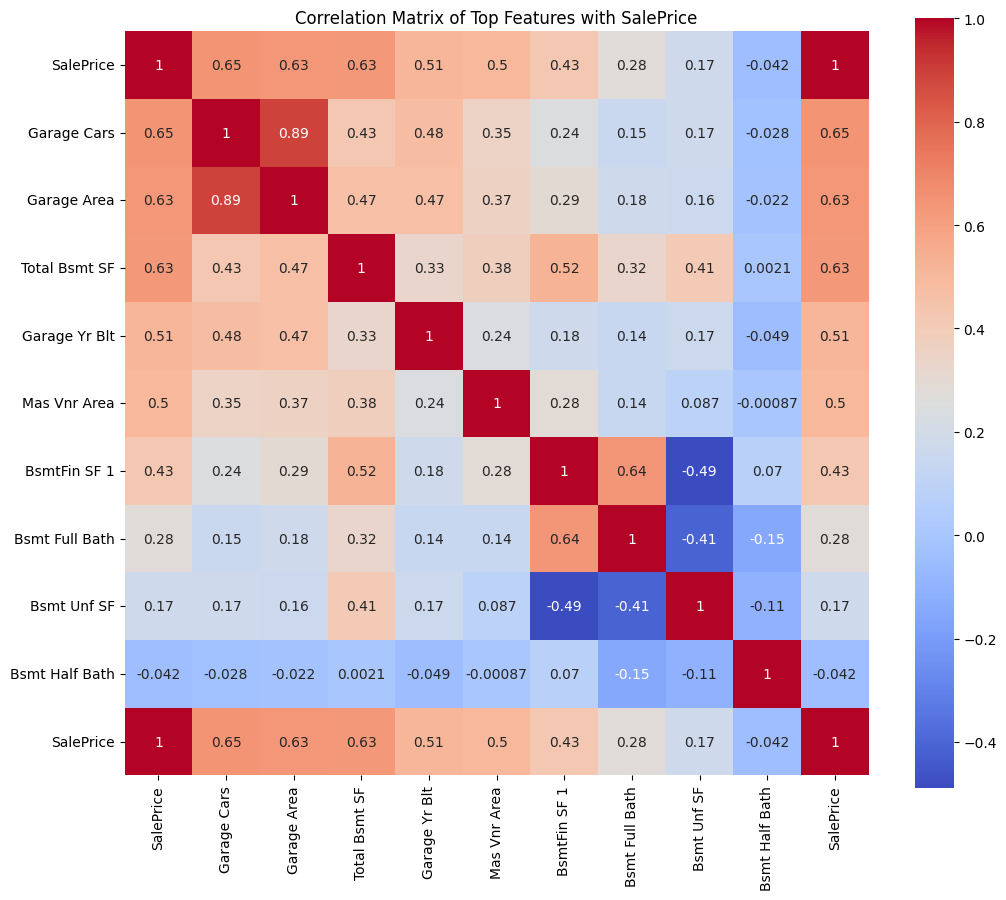

In [18]:
# Calculate correlation matrix
corr_matrix = features_for_correlation.corr()

# Extract correlations with SalePrice
saleprice_corr = corr_matrix['SalePrice'].abs().sort_values(ascending=False)

# Print the top 10 most correlated features with SalePrice
print("Top 5 features correlated with SalePrice:")
print(saleprice_corr.head(10))

# Create a heatmap of the top 10 correlated features
top_features = saleprice_corr.index[:10].tolist()
top_features.append('SalePrice')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Top Features with SalePrice')
plt.show()

### Feature Selection based on correlation

In [19]:
# Print the top 10 most correlated features with SalePrice
print("Top 10 features correlated with SalePrice:")
print(saleprice_corr.head(11))


Top 10 features correlated with SalePrice:
SalePrice         1.000000
Garage Cars       0.647207
Garage Area       0.633883
Total Bsmt SF     0.628470
Garage Yr Blt     0.512310
Mas Vnr Area      0.503488
BsmtFin SF 1      0.427674
Bsmt Full Bath    0.277146
Bsmt Unf SF       0.174573
Bsmt Half Bath    0.042454
BsmtFin SF 2      0.009326
Name: SalePrice, dtype: float64


In [20]:
# Select features with correlation > 0.5
selected_features = saleprice_corr[saleprice_corr > 0.5].index.tolist()

In [21]:
# Remove 'SalePrice' from the list if it exists
if 'SalePrice' in selected_features:
    selected_features.remove('SalePrice')

# Print selected features
print("\nSelected features (correlation > 0.5):")
print(selected_features)


Selected features (correlation > 0.5):
['Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Garage Yr Blt', 'Mas Vnr Area']


In [22]:
# Create a new dataframe with selected features
corr_features = features_for_correlation[selected_features].copy()

In [23]:

# Print the shape of the new dataframe
print(f"\nShape of selected features dataframe: {corr_features.shape}")


Shape of selected features dataframe: (2637, 5)


# 5a1- Data Preparation

In [24]:
# Print the shape of features and target
print(f"Features shape: {corr_features.shape}")
print(f"Target shape: {target.shape}")

Features shape: (2637, 5)
Target shape: (2637,)


### Splitting Training and Testing sets

In [25]:
# Data Preparation
X_train, X_test, y_train, y_test = train_test_split(corr_features, target, test_size=0.2, random_state=42)


In [26]:
# Print the shapes of the split data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2109, 5)
X_test shape: (528, 5)
y_train shape: (2109,)
y_test shape: (528,)


### Feature Scaling for corr_features

In [27]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5a- Model Creation and Eval

Root Mean Squared Error (RMSE): $48960.63
Root Mean Squared Percentage Error (RMSPE): 3.38%
R-squared: 0.6528


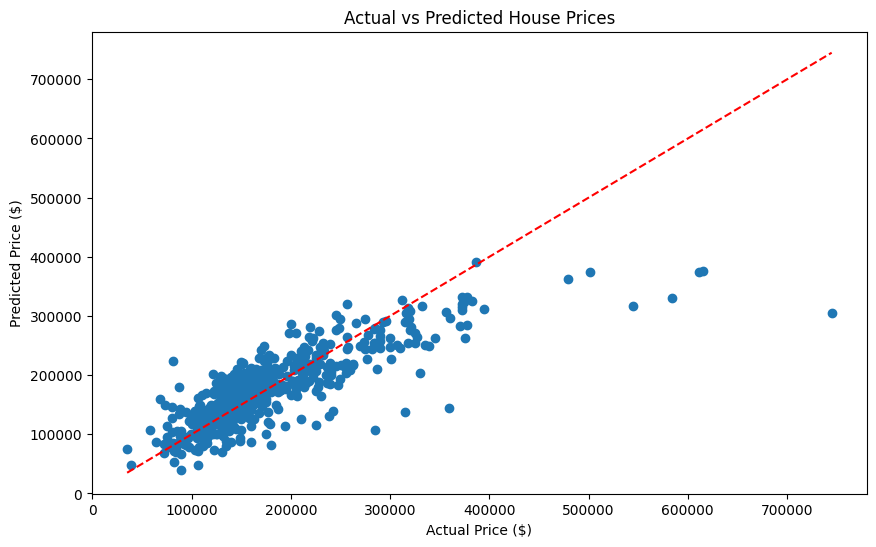

In [28]:
# Model Creation and Evaluation
# Use Ridge regression with a small alpha value to add some regularization
model = Ridge(alpha=0.1)
model.fit(X_train_scaled, y_train)

# Make predictions
predictions = model.predict(X_test_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

rmspe = np.sqrt(np.mean((predictions - y_test) / y_test)**2) * 100
print(f"Root Mean Squared Percentage Error (RMSPE): {rmspe:.2f}%")

r2 = model.score(X_test_scaled, y_test)
print(f"R-squared: {r2:.4f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()


# 5b- RFE Feature Selection


### Feature Scaling for RFE Selection

In [29]:
scaling_features = features_for_correlation.copy()
scaling_features.head()

,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area,SalePrice
0,0.0,513.0,144.0,348.0,1005.0,1.0,0.0,1964.0,2.0,440.0,115400
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1967.0,2.0,516.0,90000
2,0.0,0.0,0.0,780.0,780.0,0.0,0.0,1979.0,1.0,544.0,141000
3,0.0,484.0,0.0,491.0,975.0,1.0,0.0,2000.0,2.0,592.0,254000
4,0.0,350.0,210.0,0.0,560.0,1.0,0.0,1971.0,2.0,576.0,155000


In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaling_features, target, test_size=0.2, random_state=42)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
#  Create a linear regression model
model = LinearRegression()

# Create an RFE object with 10 features to select
rfe = RFE(model, n_features_to_select=10)

# Fit the RFE object
rfe.fit(X_train, y_train)

# Get the selected features
selected_features_rfe = X_train.columns[rfe.support_]
print("Selected features by RFE:", selected_features_rfe)

# Get feature rankings
feature_rankings = rfe.ranking_
print("\nFeature rankings:")
for feature, rank in zip(X_train.columns, feature_rankings):
    print(f"{feature}: {rank}")


Selected features by RFE: Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt',
       'Garage Cars', 'SalePrice'],
      dtype='object')

Feature rankings:
Mas Vnr Area: 1
BsmtFin SF 1: 1
BsmtFin SF 2: 1
Bsmt Unf SF: 1
Total Bsmt SF: 1
Bsmt Full Bath: 1
Bsmt Half Bath: 1
Garage Yr Blt: 1
Garage Cars: 1
Garage Area: 2
SalePrice: 1


Selected Features: Index(['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')
RMSE of RFE-selected Random Forest Model: 6884.026656233581


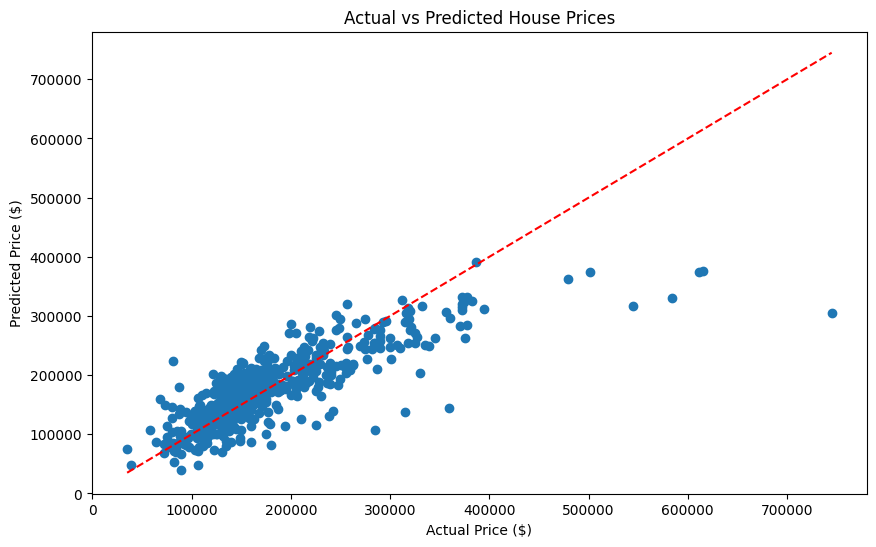

In [33]:
# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Create RFE object with 11 features to select
rfe = RFE(estimator=rf_regressor, n_features_to_select=11)

# Fit the RFE model
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# create a new Random Forest Regressor model using only the selected
new_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the new model on the selected features
X_train_selected = X_train[selected_features]
new_rf_model.fit(X_train_selected, y_train)

# evaluate our new model:
# Make predictions on the test set
X_test_selected = X_test[selected_features]
y_pred = new_rf_model.predict(X_test_selected)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE of RFE-selected Random Forest Model: {rmse}")

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()


# 5c- RFECV Feature Selection

In [34]:
# # Create a linear regression model
# model = LinearRegression()

# # Create an RFECV object
# rfecv = RFECV(estimator=model, step=1, cv=5)

# # Fit the RFECV object
# rfecv.fit(X_train, y_train)

# # Get the selected features
# selected_features_rfecv = X_train.columns[rfecv.support_]
# print("\nSelected features by RFECV:", selected_features_rfecv)

# # Print the optimal number of features
# print(f"\nOptimal number of features: {rfecv.n_features_}")

# # Plot the cross-validation scores
# plt.figure(figsize=(10, 6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")It
# plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
# plt.title("RFECV Cross Validation Scores")
# plt.show()
